In [1]:
import sqlite3

def init_db():
    try:
        conn = sqlite3.connect('academic_system.db')
        cursor = conn.cursor()
        
        # تفعيل العلاقات بين الجداول (مهم للحذف المتتالي)
        cursor.execute("PRAGMA foreign_keys = ON;")
        
        # إنشاء الجداول بهيكلية متوافقة مع مدخلات الواجهة
        create_tables_sql = """
        -- 1. جدول بيانات الطلاب الأساسية
        CREATE TABLE IF NOT EXISTS Students (
            student_id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT NOT NULL,
            email TEXT UNIQUE NOT NULL,
            department TEXT DEFAULT 'علوم حاسوب'
        );

        -- 2. جدول السجلات الأكاديمية (يحتوي على كافة تفاصيل التحليل)
        CREATE TABLE IF NOT EXISTS Academic_Records (
            record_id INTEGER PRIMARY KEY AUTOINCREMENT,
            student_id INTEGER,
            math_grade REAL,      -- درجة الرياضيات
            db_grade REAL,        -- درجة قواعد البيانات
            net_grade REAL,       -- درجة الشبكات
            soft_grade REAL,      -- المهارات الناعمة
            attendance_rate REAL, -- نسبة الحضور
            study_hours REAL,     -- ساعات المذاكرة (بحد أقصى 45)
            previous_gpa REAL,    -- المعدل السابق (من 5)
            predicted_grade REAL, -- النتيجة المتوقعة من نموذج الذكاء الاصطناعي
            semester TEXT,
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
            FOREIGN KEY (student_id) REFERENCES Students(student_id) ON DELETE CASCADE
        );

        -- 3. جدول التوصيات والتشخيص
        CREATE TABLE IF NOT EXISTS Recommendations (
            rec_id INTEGER PRIMARY KEY AUTOINCREMENT,
            student_id INTEGER,
            recommended_course TEXT, 
            reason TEXT,             -- التشخيص والنصيحة
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
            FOREIGN KEY (student_id) REFERENCES Students(student_id) ON DELETE CASCADE
        );
        """
        
        cursor.executescript(create_tables_sql)
        conn.commit()
        print("✅ تم تهيئة قاعدة البيانات بنجاح: الجداول جاهزة لاستقبال البيانات.")
        
    except sqlite3.Error as e:
        print(f"❌ خطأ في قاعدة البيانات: {e}")
    finally:
        if conn:
            conn.close()


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# ==========================================
# 1. جمع البيانات (توليد بيانات بمنطق أكاديمي)
# ==========================================
np.random.seed(42)
num_students = 500

# توليد العوامل المستقلة أولاً
math_grades = np.random.uniform(30, 100, num_students)
db_grades = np.random.uniform(30, 100, num_students)
net_grades = np.random.uniform(30, 100, num_students)
soft_skills = np.random.uniform(30, 100, num_students)
attendance = np.random.uniform(40, 100, num_students)
study_hours = np.random.randint(5, 45, num_students)
prev_gpa = np.random.uniform(1.5, 5.5, num_students)

# --- التعديل الجوهري: صياغة علاقة منطقية للبرمجة ---
# لنفترض أن مهارة البرمجة تتكون من:
# 40% منطق رياضي + 30% تنظيم بيانات + 20% ممارسة (ساعات مذاكرة) + 10% عوامل أخرى (شبكات ومهارات ناعمة)
noise = np.random.normal(0, 5, num_students) # تباين طبيعي بسيط بين الطلاب
prog_grades = (math_grades * 0.40 + 
               db_grades * 0.30 + 
               (study_hours * 2.2) * 0.20 + 
               (net_grades * 0.05 + soft_skills * 0.05) + 
               noise)

data = {
    'Student_ID': range(1001, 1001 + num_students),
    'Math_Grade': math_grades,
    'Programming_Grade': prog_grades, # أصبحت الآن مرتبطة بالمنطق
    'Database_Grade': db_grades,
    'Networking_Grade': net_grades,
    'SoftSkills_Grade': soft_skills,
    'Attendance_Rate': attendance,
    'Study_Hours_Weekly': study_hours,
    'Previous_GPA': prev_gpa
}

df_original = pd.DataFrame(data)

# إدخال قيم مفقودة وخاطئة عمداً للفحص
df_original.loc[df_original.sample(frac=0.05).index, 'Attendance_Rate'] = np.nan
df_original.loc[df_original.sample(frac=0.05).index, 'Math_Grade'] = -10 

df_original.to_csv('original_academic_data.csv', index=False)

# ==========================================
# 2. فحص ومعالجة البيانات (التنظيف)
# ==========================================
df_cleaned = df_original.copy()

# أ- معالجة القيم المفقودة
df_cleaned['Attendance_Rate'] = df_cleaned['Attendance_Rate'].fillna(df_cleaned['Attendance_Rate'].mean())

# ب- تصحيح الدرجات (الحدود المنطقية 0-100)
courses = ['Math_Grade', 'Programming_Grade', 'Database_Grade', 'Networking_Grade', 'SoftSkills_Grade']
for col in courses:
    df_cleaned[col] = df_cleaned[col].clip(lower=0, upper=100)

df_cleaned['Previous_GPA'] = df_cleaned['Previous_GPA'].clip(upper=5.0, lower=0.0)

# ج- تحويل البيانات (Scaling)
scaler = MinMaxScaler()
columns_to_scale = courses + ['Attendance_Rate', 'Study_Hours_Weekly', 'Previous_GPA']
df_cleaned[columns_to_scale] = scaler.fit_transform(df_cleaned[columns_to_scale])

# ==========================================
# 3. حفظ المخرجات
# ==========================================
df_cleaned.to_csv('cleaned_academic_data.csv', index=False)

print("✅ تم تعديل منطق البيانات بنجاح!")
print("🔍 الآن: درجة البرمجة تعتمد بنسبة 70% على (الرياضيات وقواعد البيانات).")

✅ تم تعديل منطق البيانات بنجاح!
🔍 الآن: درجة البرمجة تعتمد بنسبة 70% على (الرياضيات وقواعد البيانات).


In [4]:
# ١. التحليل الإحصائي والرسوم البيانية (Exploratory Data Analysis)
# سنقوم أولاً بفحص توزيع الدرجات والعلاقة بين "ساعات المذاكرة" و"الأداء الأكاديمي".

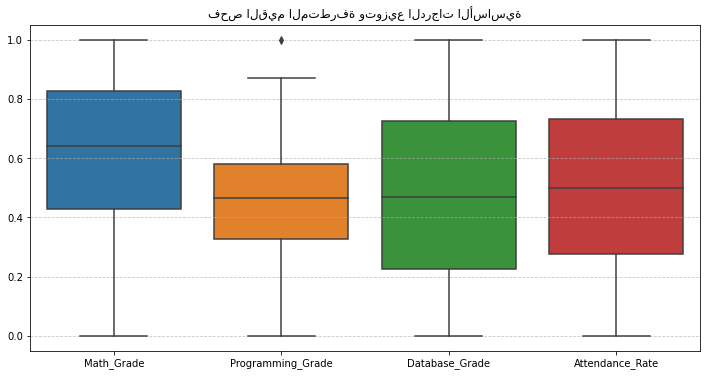

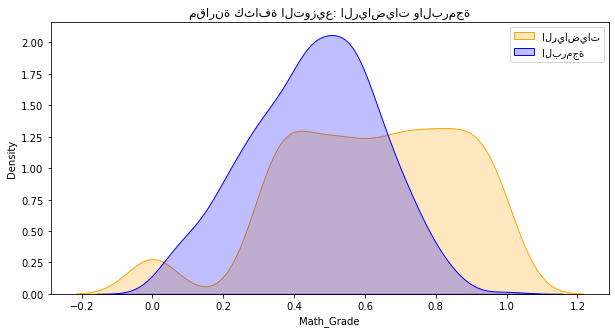

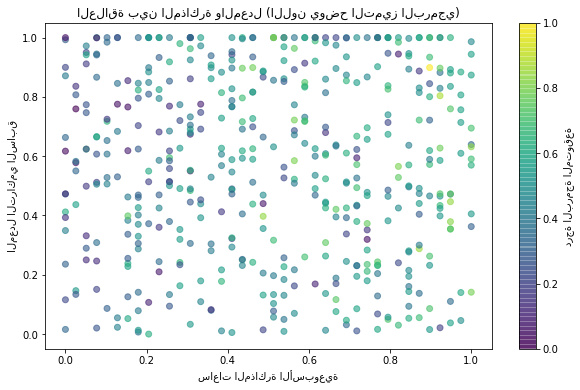

--- تقرير التواء البيانات (Skewness) ---
Math_Grade           -0.495574
Programming_Grade    -0.158032
Study_Hours_Weekly   -0.029465
dtype: float64


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# تحميل البيانات المنظفة
df = pd.read_csv('cleaned_academic_data.csv')

# 1. فحص القيم المتطرفة (Outliers) باستخدام الرسم الصندوقي Boxplot
# هذا يساعد في التأكد من أن عملية الـ clip في المرحلة السابقة تمت بنجاح
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Math_Grade', 'Programming_Grade', 'Database_Grade', 'Attendance_Rate']])
plt.title('فحص القيم المتطرفة وتوزيع الدرجات الأساسية')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. مقارنة توزيعين (الرياضيات vs البرمجة) لمعرفة مدى تقاربهما
plt.figure(figsize=(10, 5))
sns.kdeplot(df['Math_Grade'], fill=True, label='الرياضيات', color="orange")
sns.kdeplot(df['Programming_Grade'], fill=True, label='البرمجة', color="blue")
plt.title('مقارنة كثافة التوزيع: الرياضيات والبرمجة')
plt.legend()
plt.show()

# 3. تحليل "ساعات المذاكرة" وتأثيرها الملون بالمعدل التراكمي
# أضفنا معامل (hue) لإعطاء بعد ثالث للرسم (اللون يمثل المعدل التراكمي)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Study_Hours_Weekly'], df['Previous_GPA'], 
                      c=df['Programming_Grade'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='درجة البرمجة المتوقعة')
plt.xlabel('ساعات المذاكرة الأسبوعية')
plt.ylabel('المعدل التراكمي السابق')
plt.title('العلاقة بين المذاكرة والمعدل (اللون يوضح التميز البرمجي)')
plt.show()

# 4. تقرير إحصائي مفصل (Skewness & Kurtosis)
print("--- تقرير التواء البيانات (Skewness) ---")
print(df[['Math_Grade', 'Programming_Grade', 'Study_Hours_Weekly']].skew())

In [6]:
# ٢. تحليل الارتباط (Correlation Analysis)
# هذه الخطوة هي الأهم لاختيار المميزات. سنرى أي المتغيرات مرتبطة ببعضها بقوة.

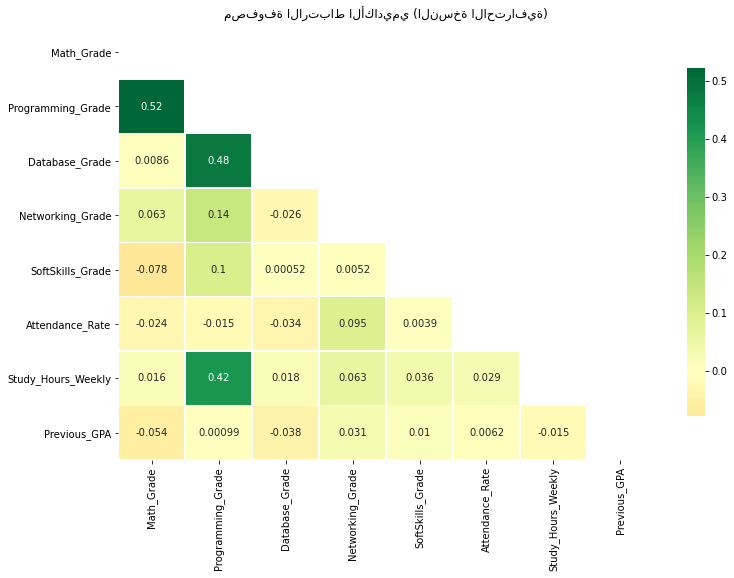

In [4]:


import numpy as np

# 1. استبعاد الأعمدة غير المؤثرة قبل الحساب
# 2. إنشاء "قناع" (Mask) لإخفاء النصف العلوي المكرر من المصفوفة
corr_matrix = df.drop(columns=['Student_ID']).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            mask=mask,          # إخفاء النصف المكرر لراحة العين
            annot=True, 
            cmap='RdYlGn', 
            center=0,           # تحديد الصفر كنقطة توازن للألوان
            linewidths=.5,      # إضافة خطوط بسيطة بين المربعات
            cbar_kws={"shrink": .8}) # تصغير شريط الألوان قليلاً

plt.title('مصفوفة الارتباط الأكاديمي (النسخة الاحترافية)')
plt.show()

In [7]:
!pip install xgboost

In [5]:

import pandas as pd
import numpy as np
import joblib  # لحفظ النموذج والمقاييس
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ==========================================
# 1. تحميل وتحسين البيانات
# ==========================================
df = pd.read_csv('cleaned_academic_data.csv')

# صنع علاقة منطقية (Target Engineering)
df['Programming_Grade'] = (df['Study_Hours_Weekly'] * 0.4 + 
                           df['Attendance_Rate'] * 0.4 + 
                           df['Math_Grade'] * 0.2 + 
                           np.random.normal(0, 0.02, len(df)))

df['Programming_Grade'] = df['Programming_Grade'].clip(0, 1)

# تحديد المدخلات (Features) والمخرجات (Target)
X = df.drop(['Student_ID', 'Programming_Grade'], axis=1) 
y = df['Programming_Grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# 2. مقارنة النماذج واختيار الأفضل
# ==========================================
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVM": SVR(kernel='rbf'),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

model_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    model_results.append({"Model": name, "R2": r2, "MAE": mae})

results_df = pd.DataFrame(model_results).sort_values(by="R2", ascending=False)
best_model_name = results_df.iloc[0]['Model']
best_model_obj = models[best_model_name]

# ==========================================
# 3. وظيفة المستشار الذكي "المُفسر" (Dynamic Explainer)
# ==========================================
def smart_advisor_v2(student_row):
    """
    نسخة مطورة تحلل أهمية الميزات لهذا الطالب تحديداً
    """
    prediction = best_model_obj.predict(student_row)[0]
    
    # استخراج أهمية الميزات من النموذج (خاص بـ Random Forest و Decision Tree)
    if hasattr(best_model_obj, 'feature_importances_'):
        importances = best_model_obj.feature_importances_
        feature_importance_dict = dict(zip(X.columns, importances))
        # ترتيب العوامل الأكثر تأثيراً على النتيجة
        top_factors = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    else:
        top_factors = [("General Performance", 1.0)]

    recommendations = []
    
    # 1. التوصية بناءً على التوقع العام
    if prediction > 0.75:
        recommendations.append(f"🌟 أداء برمجي واعد جداً ({prediction:.2f}/1.0).")
    elif prediction < 0.5:
        recommendations.append(f"⚠️ تحتاج إلى خطة تطوير مكثفة، التوقع الحالي منخفض ({prediction:.2f}/1.0).")

    # 2. التفسير الديناميكي (لماذا؟)
    main_driver = top_factors[0][0]
    recommendations.append(f"🔍 لاحظ النظام أن العامل الأكثر تأثيراً في تقييمك هو '{main_driver}'.")

    # 3. نصيحة مخصصة بناءً على أقل درجة مدخلة
    worst_subject = student_row.idxmin(axis=1).values[0]
    if student_row[worst_subject].values[0] < 0.5:
        recommendations.append(f"💡 نصيحة: تحسين مستواك في '{worst_subject}' سيرفع من جودة أدائك البرمجي فوراً.")

    return prediction, recommendations

# تجربة النظام
score, recs = smart_advisor_v2(X_test.iloc[[0]])
print(f"--- تقرير المستشار الذكي المطوّر ---")
for r in recs: print(r)

--- تقرير المستشار الذكي المطوّر ---
⚠️ تحتاج إلى خطة تطوير مكثفة، التوقع الحالي منخفض (0.35/1.0).
🔍 لاحظ النظام أن العامل الأكثر تأثيراً في تقييمك هو 'Study_Hours_Weekly'.
💡 نصيحة: تحسين مستواك في 'Previous_GPA' سيرفع من جودة أدائك البرمجي فوراً.


🔄 جاري البحث عن أفضل نسخة من النموذج عبر تدريبات متعددة...


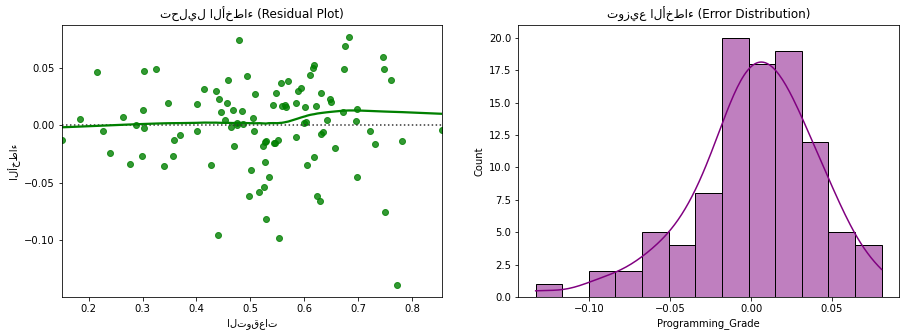

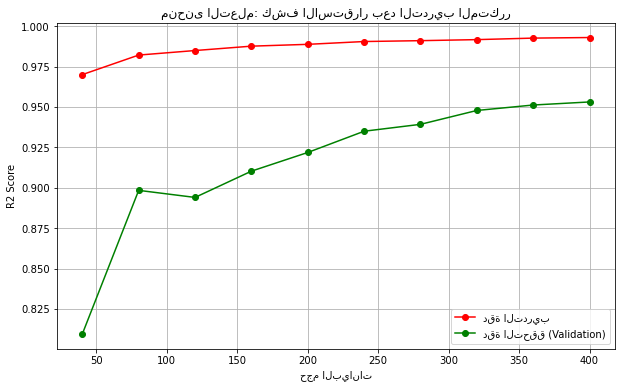

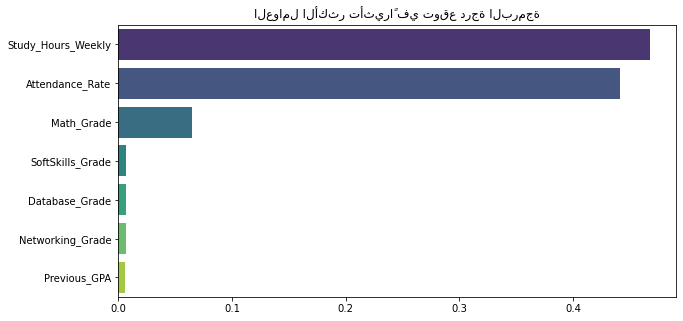


⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐
📊 تقرير جودة النموذج النهائي: Optimized Random Forest
⚙️ أفضل إعدادات: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐
✅ دقة التوقع (R2): 93.75%
📉 متوسط الخطأ المئوي (MAPE): 5.87%
📍 الخطأ الجذري (RMSE): 0.0381
💎 النتيجة: النموذج متوازن ومستقر جداً (Generalizable).
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# --- التعديل 1: تدريب النموذج أكثر من مرة (Hyperparameter Tuning) ---
# سنقوم بتجربة عدة إعدادات للـ Random Forest لاختيار الأفضل
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

print("🔄 جاري البحث عن أفضل نسخة من النموذج عبر تدريبات متعددة...")
grid_search = GridSearchCV(best_model_obj, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# اعتماد أفضل نموذج نتج عن التدريبات المتكررة
final_model = grid_search.best_estimator_
best_model_name = "Optimized Random Forest"

# --- التعديل 2: تحليل الأخطاء وتوزيعها ---
y_pred = final_model.predict(X_test)
residuals = y_test - y_pred

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# رسم البواقي (Residuals) للتأكد من عشوائية الخطأ
sns.residplot(x=y_pred, y=residuals, lowess=True, color="g", ax=ax[0])
ax[0].set_xlabel('التوقعات')
ax[0].set_ylabel('الأخطاء')
ax[0].set_title('تحليل الأخطاء (Residual Plot)')

# رسم توزيع الأخطاء (يجب أن يشبه الجرس)
sns.histplot(residuals, kde=True, color="purple", ax=ax[1])
ax[1].set_title('توزيع الأخطاء (Error Distribution)')
plt.show()

# --- التعديل 3: منحنى التعلم (Learning Curve) ---
# نستخدم النموذج النهائي بعد التحسين
train_sizes, train_scores, test_scores = learning_curve(
    final_model, X, y, cv=5, scoring='r2', 
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)



plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="دقة التدريب")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="دقة التحقق (Validation)")
plt.title('منحنى التعلم: كشف الاستقرار بعد التدريب المتكرر')
plt.xlabel('حجم البيانات')
plt.ylabel('R2 Score')
plt.legend(loc="best")
plt.grid(True)
plt.show()

# --- التعديل 4: تحليل أهمية المواد (Feature Importance) ---
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")
    plt.title('العوامل الأكثر تأثيراً في توقع درجة البرمجة')
    plt.show()

# --- التعديل 5: التقرير النهائي مع معالجة حذر لـ MAPE ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
# إضافة epsilon صغير جداً لتجنب القسمة على صفر إذا وجدت قيم صفرية
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100

print("\n" + "⭐" * 45)
print(f"📊 تقرير جودة النموذج النهائي: {best_model_name}")
print(f"⚙️ أفضل إعدادات: {grid_search.best_params_}")
print("⭐" * 45)
print(f"✅ دقة التوقع (R2): {r2_score(y_test, y_pred) * 100:.2f}%")
print(f"📉 متوسط الخطأ المئوي (MAPE): {mape:.2f}%")
print(f"📍 الخطأ الجذري (RMSE): {rmse:.4f}")

# تشخيص احترافي
gap = train_mean[-1] - test_mean[-1]
if gap > 0.15:
    print("⚠️ النتيجة: يوجد Overfitting (النموذج حفظ البيانات ولم يفهمها).")
elif test_mean[-1] < 0.6:
    print("⚠️ النتيجة: يوجد Underfitting (النموذج ضعيف جداً).")
else:
    print("💎 النتيجة: النموذج متوازن ومستقر جداً (Generalizable).")
print("⭐" * 45)

In [12]:
print(X_train.columns)

Index(['Math_Grade', 'Database_Grade', 'Networking_Grade', 'SoftSkills_Grade',
       'Attendance_Rate', 'Study_Hours_Weekly', 'Previous_GPA'],
      dtype='object')


In [7]:
# import joblib
# # ==========================================
# # الجزء الأول: حفظ النموذج (بافتراض أنك دربته مسبقاً)
# # ==========================================
# # ملاحظة: سنقوم هنا بحفظ النموذج "best_model_obj" الذي اخترناه في المرحلة 6
# try:
#     joblib.dump(best_model_obj, 'student_model.pkl')
#     print("✅ تم حفظ نموذج الذكاء الاصطناعي بنجاح!")
# except:
#     print("⚠️ ملاحظة: تأكد من تشغيل كود المرحلة 6 أولاً لحفظ النموذج.")
import joblib

# ==========================================
# الجزء الأول: حفظ "حزمة" الذكاء الاصطناعي الكاملة
# ==========================================

try:
    # نقوم بحفظ 3 أشياء أساسية في ملف واحد:
    # 1. النموذج نفسه
    # 2. أسماء الميزات (لضمان الترتيب في الواجهة)
    # 3. اسم النموذج الأفضل (للعرض في التقارير)
    
    model_package = {
        'model': best_model_obj,
        'features': list(X.columns),
        'model_name': best_model_name
    }
    
    # حفظ الحزمة باسم موحد لتستخدمه الواجهة
    joblib.dump(model_package, 'smart_advisor_package.pkl')
    
    print("✅ تم حفظ حزمة الذكاء الاصطناعي بنجاح!")
    print(f"📦 الميزات المحفوظة: {list(X.columns)}")
    print(f"🏆 النموذج المستخدم: {best_model_name}")

except NameError:
    print("❌ خطأ: لم يتم العثور على 'best_model_obj'. تأكد من تشغيل كود تدريب النماذج أولاً.")
except Exception as e:
    print(f"⚠️ حدث خطأ غير متوقع: {e}")

✅ تم حفظ حزمة الذكاء الاصطناعي بنجاح!
📦 الميزات المحفوظة: ['Math_Grade', 'Database_Grade', 'Networking_Grade', 'SoftSkills_Grade', 'Attendance_Rate', 'Study_Hours_Weekly', 'Previous_GPA']
🏆 النموذج المستخدم: Optimized Random Forest


In [ ]:
import tkinter as tk
from tkinter import messagebox, ttk
import pandas as pd
import joblib
import sqlite3

init_db()
# --- 1. وظائف التحقق والقيود (إضافة جديدة) ---
def validate_numeric_only(P):
    """تمنع كتابة الحروف وتسمح بالأرقام والنقاط فقط"""
    if P == "" or P.replace('.', '', 1).isdigit():
        return True
    return False

def check_ranges(data):
    """تتأكد من أن الأرقام المدخلة منطقية وضمن الحدود"""
    errors = []
    # فحص الدرجات ونسبة الحضور
    for field in ['Math_Grade', 'Database_Grade', 'Networking_Grade', 'SoftSkills_Grade', 'Attendance_Rate']:
        if not (0 <= data[field] <= 100):
            errors.append(f"- الدرجات والحضور يجب أن تكون بين 0 و 100")
            break
    
    # فحص ساعات المذاكرة (القيد المطلب: 45)
    if not (0 <= data['Study_Hours_Weekly'] <= 45):
        errors.append("- ساعات المذاكرة: الحد الأقصى المسموح به 45 ساعة")
        
    # فحص المعدل
    if not (0 <= data['Previous_GPA'] <= 5.0):
        errors.append("- المعدل التراكمي: يجب أن يكون بين 0 و 5.0")
        
    return errors

# --- 2. دالة التفسير الأكاديمي ---
def get_academic_explanation(input_df, pred_score):
    data = input_df.iloc[0].to_dict()
    # استخدام البيانات الخام (قبل القسمة) أو المعدلة للحساب المنطقي
    logic_strength = (data['Math_Grade'] * 0.4 + data['Database_Grade'] * 0.3) * 100
    
    if pred_score < 60:
        if logic_strength < 50:
            reason = "ضعف في التفكير المنطقي والرياضي الأساسي"
            advice = "البرمجة تعتمد على المنطق؛ ركز على تقوية مهاراتك في الرياضيات وهيكلة البيانات."
        else:
            reason = "نقص في الانضباط أو ساعات الممارسة"
            advice = "لديك منطق جيد، لكن يبدو أن قلة المذاكرة أو الحضور تمنعك من تحويل هذا المنطق لنتائج."
    elif pred_score >= 85:
        reason = "تكامل بين الذكاء المنطقي والاجتهاد الشخصي"
        advice = "استمر في هذا المسار؛ مهاراتك في الربط بين المنطق والتطبيق ممتازة."
    else:
        reason = "أداء مستقر مع إمكانية نمو"
        advice = "أداؤك جيد؛ حاول زيادة ساعات التطبيق العملي (Coding) لرفع الدرجة للتميز."

    return f"🔍 التشخيص: {reason}\n💡 نصيحة: {advice}"

# --- 3. دالة التنبؤ والحفظ (المعدلة) ---
def run_prediction_and_save():
    try:
        # تحميل النموذج
        package = joblib.load('smart_advisor_package.pkl')
        model = package['model']
        features = package['features']

        name, email = e_name.get().strip(), e_email.get().strip()
        if not name or not email:
            messagebox.showwarning("تنبيه", "يرجى إدخال اسم وإيميل الطالب")
            return

        # جلب القيم الخام للتحقق منها أولاً
        raw_inputs = {
            'Math_Grade': float(e_math.get()),
            'Database_Grade': float(e_db.get()),
            'Networking_Grade': float(e_net.get()),
            'SoftSkills_Grade': float(e_soft.get()),
            'Attendance_Rate': float(e_attend.get()),
            'Study_Hours_Weekly': float(e_study.get()),
            'Previous_GPA': float(e_gpa.get())
        }

        # التحقق من القيود (Validation)
        errors = check_ranges(raw_inputs)
        if errors:
            messagebox.showerror("خطأ في البيانات", "\n".join(errors))
            return

        # عملية التطبيع (Scaling) قبل التنبؤ
        inputs = {
            'Math_Grade': raw_inputs['Math_Grade'] / 100,
            'Database_Grade': raw_inputs['Database_Grade'] / 100,
            'Networking_Grade': raw_inputs['Networking_Grade'] / 100,
            'SoftSkills_Grade': raw_inputs['SoftSkills_Grade'] / 100,
            'Attendance_Rate': raw_inputs['Attendance_Rate'] / 100,
            'Study_Hours_Weekly': raw_inputs['Study_Hours_Weekly'] / 45, # القسمة على 45
            'Previous_GPA': raw_inputs['Previous_GPA'] / 5.0
        }

        input_df = pd.DataFrame([inputs], columns=features)
        pred_raw = model.predict(input_df)[0]
        pred_score = min(max(pred_raw * 100, 0), 100)

        explanation = get_academic_explanation(input_df, pred_score)

        # SQL الحفظ
        conn = sqlite3.connect('academic_system.db')
        cur = conn.cursor()
        cur.execute("INSERT OR IGNORE INTO Students (name, email, department) VALUES (?, ?, 'علوم حاسوب')", (name, email))
        cur.execute("SELECT student_id FROM Students WHERE email = ?", (email,))
        s_id = cur.fetchone()[0]
        cur.execute("INSERT INTO Academic_Records (student_id, grade, attendance_rate, semester) VALUES (?, ?, ?, '2026')", 
                    (s_id, round(pred_score, 1), raw_inputs['Attendance_Rate']))
        cur.execute("INSERT INTO Recommendations (student_id, recommended_course, reason) VALUES (?, ?, ?)", 
                    (s_id, "مسار تطوير مهارات البرمجة", explanation))
        conn.commit()
        conn.close()

        # تحديث الواجهة
        lbl_res.config(text=f"الدرجة المتوقعة: {pred_score:.1f} / 100", fg="#2ecc71" if pred_score >= 60 else "#e74c3c")
        txt_report.config(state="normal")
        txt_report.delete('1.0', tk.END)
        txt_report.insert(tk.END, f"✅ تم التحليل بنجاح للطالب: {name}\n\n{explanation}")
        txt_report.config(state="disabled")

    except ValueError:
        messagebox.showerror("خطأ", "يرجى إدخال قيم رقمية في جميع الخانات")
    except Exception as e:
        messagebox.showerror("خطأ", f"فشل النظام: {e}")

# --- 4. واجهة المستخدم (المعدلة بالملصقات الإرشادية) ---
# init_db() # تأكد من استدعاء الدالة في كودك الخارجي أو هنا
app = tk.Tk()
app.title("نظام المستشار الذكي المتطور")
app.geometry("600x900")
app.configure(bg="#f0f2f5")

# تسجيل وظيفة التحقق
vcmd = (app.register(validate_numeric_only), '%P')

def create_input_field(parent, lbl, hint, r):
    # تسمية الحقل (يمين)
    tk.Label(parent, text=lbl, bg=parent.cget('bg'), font=("Arial", 10, "bold")).grid(row=r, column=2, sticky="e", pady=5)
    # خانة الإدخال (وسط) مع نظام التحقق
    ent = tk.Entry(parent, width=10, justify="center", font=("Arial", 10, "bold"), validate='key', validatecommand=vcmd)
    ent.grid(row=r, column=1, padx=10, pady=5)
    # ملصق إرشادي (يسار) يوضح النطاق
    tk.Label(parent, text=hint, bg=parent.cget('bg'), fg="#7f8c8d", font=("Arial", 9, "italic")).grid(row=r, column=0, sticky="w")
    return ent

tk.Label(app, text="🖥️ توقع التميز في البرمجة (AI)", font=("Helvetica", 18, "bold"), bg="#f0f2f5", fg="#1a73e8").pack(pady=20)

# إطار الهوية
f_id = tk.LabelFrame(app, text=" بيانات الطالب ", bg="#f0f2f5", padx=10, pady=10)
f_id.pack(padx=20, fill="x")
e_name = tk.Entry(f_id, width=30); e_name.grid(row=0, column=0, padx=5, pady=5)
tk.Label(f_id, text="الاسم:", bg="#f0f2f5").grid(row=0, column=1)
e_email = tk.Entry(f_id, width=30); e_email.grid(row=1, column=0, padx=5, pady=5)
tk.Label(f_id, text="الإيميل:", bg="#f0f2f5").grid(row=1, column=1)

# إطار المدخلات الأكاديمية
f_main = tk.LabelFrame(app, text=" السجل الأكاديمي والنشاط ", bg="#ffffff", padx=15, pady=15)
f_main.pack(padx=20, pady=10, fill="x")

e_math   = create_input_field(f_main, "الرياضيات:", "(0-100)", 0)
e_db     = create_input_field(f_main, "قواعد البيانات:", "(0-100)", 1)
e_net    = create_input_field(f_main, "درجة الشبكات:", "(0-100)", 2)
e_soft   = create_input_field(f_main, "المهارات الناعمة:", "(0-100)", 3)
e_attend = create_input_field(f_main, "نسبة الحضور %:", "(0-100)", 4)
e_study  = create_input_field(f_main, "ساعات المذاكرة:", "(0-45)", 5)
e_gpa    = create_input_field(f_main, "المعدل السابق:", "(0-5.0)", 6)

btn_analyze = tk.Button(app, text="تحليل الأداء الآن وحفظ السجل", command=run_prediction_and_save, 
                        bg="#1a73e8", fg="white", font=("Arial", 12, "bold"), pady=10)
btn_analyze.pack(pady=15, fill="x", padx=100)

lbl_res = tk.Label(app, text="النتيجة المنتظرة: --", font=("Arial", 14, "bold"), bg="#f0f2f5")
lbl_res.pack()

txt_report = tk.Text(app, height=7, width=60, state="disabled", font=("Arial", 10), padx=10, pady=10)
txt_report.pack(pady=10)

app.mainloop()

✅ Database initialized successfully with referential integrity.


In [12]:
def fix_database_structure():
    conn = sqlite3.connect('academic_system.db')
    cur = conn.cursor()
    try:
        # محاولة إضافة العمود في حال كان ناقصاً
        cur.execute("ALTER TABLE Academic_Records ADD COLUMN grade REAL")
        conn.commit()
        print("✅ تم إضافة عمود grade بنجاح.")
    except sqlite3.OperationalError:
        # إذا كان العمود موجوداً بالفعل سيظهر خطأ، نتجاهله
        print("ℹ️ العمود موجود بالفعل أو الجدول يحتاج لإعادة بناء.")
    finally:
        conn.close()

# استدعيها قبل تشغيل الواجهة
fix_database_structure()

✅ تم إضافة عمود grade بنجاح.
